# 04. Pytorch Custom Datasets Notebook

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 + is required for this cource
torch.__version__

'2.3.0+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food 101 dataset.

Food101 starts 101 different classes of food.

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, ~25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## 2. Becoming one with the data (data preparation and data exploration

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returnign its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

data/pizza_steak_sushi/test/steak/1868005.jpg
steak
Random image path: data/pizza_steak_sushi/test/steak/1868005.jpg
Image class: steak
Image height: 512
Image width: 512


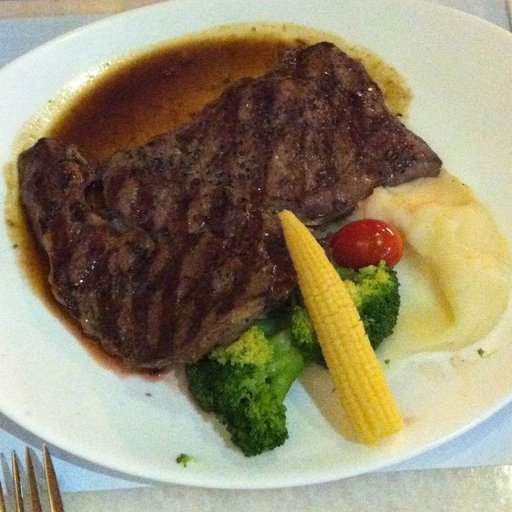

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [8]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


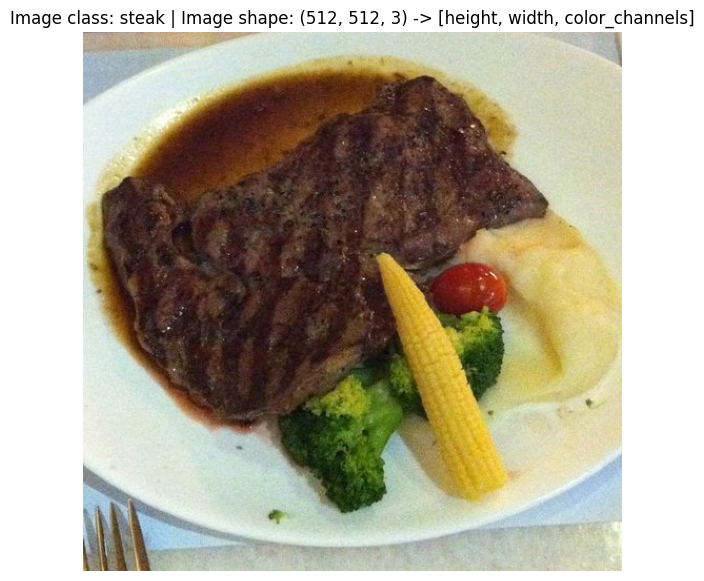

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [10]:
img_as_array

array([[[139, 128, 110],
        [152, 141, 123],
        [148, 136, 120],
        ...,
        [200, 183, 163],
        [209, 191, 169],
        [220, 202, 180]],

       [[175, 164, 146],
        [173, 162, 144],
        [170, 158, 142],
        ...,
        [205, 188, 168],
        [209, 191, 169],
        [212, 194, 172]],

       [[184, 171, 152],
        [178, 165, 146],
        [175, 162, 145],
        ...,
        [186, 169, 149],
        [203, 185, 163],
        [219, 201, 179]],

       ...,

       [[183, 156,  79],
        [173, 146,  77],
        [153, 130,  80],
        ...,
        [218, 218, 182],
        [220, 217, 182],
        [220, 217, 182]],

       [[204, 175,  97],
        [190, 163,  92],
        [157, 134,  82],
        ...,
        [221, 219, 181],
        [222, 220, 182],
        [225, 223, 185]],

       [[220, 191, 111],
        [196, 169,  98],
        [153, 128,  74],
        ...,
        [216, 214, 176],
        [213, 211, 173],
        [219, 217, 179]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1.  Turn your target data into tensors (in our case, numerical representation of our images).
2.  Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly the horizontal
    # transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img).shape

torch.Size([3, 224, 224])

In [14]:
data_transform(img).dtype

torch.float32

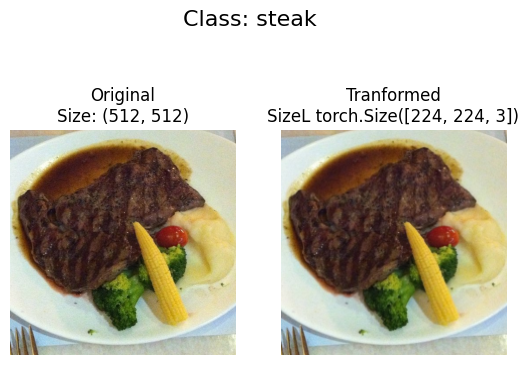

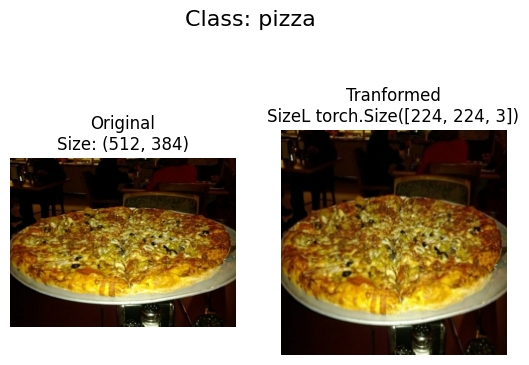

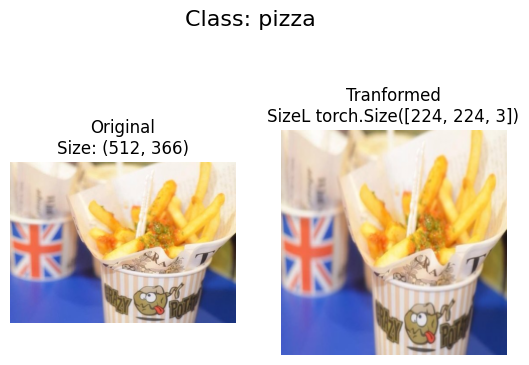

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # permute you specify which spots each of the elemetns of the array goes.  Ex) 1->0, 2->1, 0->3
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Tranformed\nSizeL {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [17]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [22]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1098, 0.1098, 0.1098,  ..., 0.1255, 0.1176, 0.1137],
         [0.1137, 0.1176, 0.1176,  ..., 0.1137, 0.1137, 0.1176],
         [0.1216, 0.1255, 0.1216,  ..., 0.1098, 0.1176, 0.1137],
         ...,
         [0.1804, 0.1725, 0.1725,  ..., 0.0863, 0.0902, 0.0941],
         [0.1686, 0.1686, 0.1647,  ..., 0.0902, 0.0902, 0.0902],
         [0.1529, 0.1529, 0.1490,  ..., 0.0824, 0.0863, 0.0863]],

        [[0.0549, 0.0549, 0.0549,  ..., 0.0824, 0.0745, 0.0706],
         [0.0588, 0.0627, 0.0627,  ..., 0.0706, 0.0706, 0.0745],
         [0.0627, 0.0667, 0.0627,  ..., 0.0667, 0.0784, 0.0706],
         ...,
         [0.2314, 0.2314, 0.2353,  ..., 0.1020, 0.1059, 0.1098],
         [0.2314, 0.2314, 0.2275,  ..., 0.1059, 0.1059, 0.1059],
         [0.2235, 0.2235, 0.2196,  ..., 0.0980, 0.1020, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.1059, 0.0980, 0.0941],
         [0.0196, 0.0235, 0.0235,  ..., 0.0941, 0.0941, 0.0980],
         [0.0196, 0.0235, 0.0235,  ..., 0.09

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute: torch.Size([224, 224, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

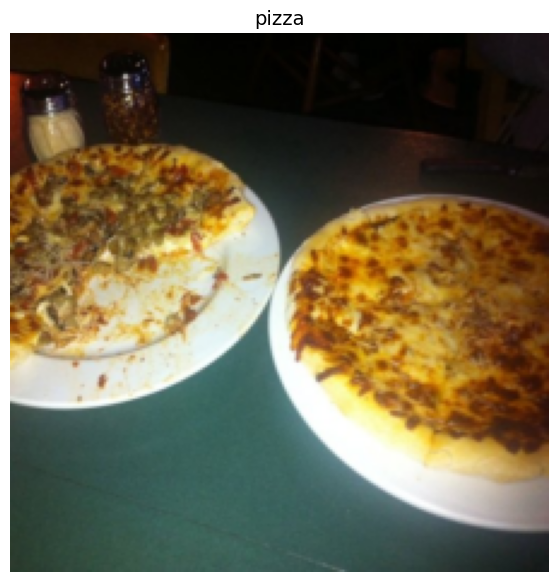

In [26]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [28]:
import os
os.cpu_count()

48

In [32]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x74ec22a7e8d0>,
 <torch.utils.data.dataloader.DataLoader at 0x74ec34fddf40>)

In [33]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [34]:
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = 